### Load Data

In [2]:
import pandas as pd
import numpy as np

# Make sure it prints the whole array
np.set_printoptions(threshold=np.inf)

df = pd.read_parquet("../data/raw/guitar_sample_parquet")
df.head()

,video_id,title,description,tags,publishedAt,channelTitle,viewCount,likeCount,duration,raw_snippet,raw_statistics,level,topic
0,WN4IoK7ecAU,How to Teach Yourself Guitar in 2025 (Save YEA...,Are you part of the 90% of aspiring guitarists...,"[O.R.-Guitar, how to play, guitar lesson, guit...",2024-02-05T04:46:37Z,Oryam Bisset,3929627,200481.0,PT10M40S,"{'categoryId': '10', 'channelId': 'UCXUJSxAjaQ...","{'commentCount': '4518', 'favoriteCount': '0',...",beginner,Chords
1,4WVkDrb6d5A,"A Good, Quick Intermediate Guitar Lesson",Trying to combine a few concepts into one flui...,"[guitar, sean daniel, guitar lesson, sean dani...",2021-08-15T13:00:02Z,Sean Daniel,162898,3853.0,PT12M41S,"{'categoryId': '10', 'channelId': 'UCzZCiVjRPP...","{'commentCount': '147', 'favoriteCount': '0', ...",intermediate,Learning songs
2,sDjeY1jI2Z8,5 GREAT chord tricks everyone should know!,▶MY NEW COURSE◀ http://nextlevelplaying.com\nK...,"[paul davids, acoustic, great, tricks, chord t...",2020-03-14T16:59:33Z,Paul Davids,2607896,106352.0,PT14M21S,"{'categoryId': '10', 'channelId': 'UC_Oa7Ph3v9...","{'commentCount': '2372', 'favoriteCount': '0',...",unknown,Chords
3,-iV-7XhUMT0,Are You An Intermediate Or Advanced Guitar Pla...,More Guitar Resources:\n🎵 Get my FREE Guitar G...,"[Marty Schwartz, music, guitar, marty music, g...",2020-09-25T14:00:00Z,Marty Music,165257,4978.0,PT10M7S,"{'categoryId': '10', 'channelId': 'UCmnlTWVJys...","{'commentCount': '962', 'favoriteCount': '0', ...",intermediate,Chords
4,wH63GHXTHgU,Advanced Chords Practice Routine - Guitar Less...,"Gain access to TABS, exclusive tutorials and o...","[jazz guitar chords, advanced guitar chords le...",2020-05-05T14:46:45Z,swiftlessons,433497,14386.0,PT16M8S,"{'categoryId': '10', 'channelId': 'UCjdxyPMmti...","{'commentCount': '345', 'favoriteCount': '0', ...",beginner,Chords


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804 entries, 0 to 1803
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        1804 non-null   object 
 1   title           1804 non-null   object 
 2   description     1804 non-null   object 
 3   tags            1804 non-null   object 
 4   publishedAt     1804 non-null   object 
 5   channelTitle    1804 non-null   object 
 6   viewCount       1804 non-null   int64  
 7   likeCount       1787 non-null   float64
 8   duration        1804 non-null   object 
 9   raw_snippet     1804 non-null   object 
 10  raw_statistics  1804 non-null   object 
 11  level           1804 non-null   object 
 12  topic           1804 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 183.3+ KB


In [4]:
# Check how many unknowns
df["level"].value_counts()

level
intermediate    754
unknown         543
beginner        477
advance          30
Name: count, dtype: int64

In [5]:
# Map ordinal labels to numbers
level_map = {"beginner": 1, "intermediate": 2, "advance": 3}
df["level_rank"] = df["level"].map(level_map)

In [25]:
from sklearn.model_selection import train_test_split

# Remove rows with the values of unknown, they'll be saved for the test dataset
level_unknown_df = df.query('level == "unknown"')
df_copy = df.drop(level_unknown_df.index, inplace=False)

X = df_copy[["title", "description"]].copy()
y = df_copy["level_rank"]

X['text'] = X["title"] + " " + X["description"]
X = X[['text']]

# split_size = int(0.8 * len(df_copy))

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

# train_df = df_copy.iloc[:split_size].copy()
# val_df = df_copy.iloc[split_size:].copy()


# train_df.shape, val_df.shape, test_df.shape
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1008, 1), (253, 1), (1008,), (253,))

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
X_val_tfidf = vectorizer.transform(X_val["text"])

print(X_train_tfidf.shape)
print(len(y_train))

(1008, 5609)
1008


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, r2_score

models = {
    "naive_bayes": MultinomialNB(),
    "linear_regression": LinearRegression(),
    "random_forest_reg": RandomForestRegressor()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    y_pred = np.round(y_pred)
    print(f"{name}_score: {model.score(X=X_val_tfidf, y=y_val)}")
    print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
    print("R2 Score:", r2_score(y_val, y_pred))
    print("Predictions:", y_pred)
    

naive_bayes_score: 0.8379446640316206
RMSE: 0.41702882811414954
R2 Score: 0.385176184690158
Predictions: [2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2.
 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 1.
 2. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2. 2. 1. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1.
 2. 2. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 1. 2. 2. 1. 2.
 1. 2. 2. 2. 2. 2. 1. 2. 2. 1. 2. 1. 1. 2. 2. 1. 1. 1. 2. 2. 1. 1. 2. 1.
 2. 1. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 1. 1.
 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.]
linear_regression_score: 0.8570090791415771
RMSE: 0.20851441405707477
R2 Score: 0.8462940461725394
Predictions: [3. 3. 1. 2.

In [ ]:
# test_df = level_unknown_df.copy()

# test_df.to_csv("../data/raw/guitar_sample_test.csv")

In [24]:
# level_map = {"beginner": 1, "intermediate": 2, "advanced": 3}

# train_level_labels = train_df["level"].map(level_map).to_list()
# val_level_labels = val_df["level"].map(level_map).to_list()

# print(train_level_labels)

In [18]:
# train_topic_labels = train_df["topic"]
# val_topic_labels = val_df["topic"]
# test_topic_labels = test_df["topic"]
# print('\n'.join(train_topic_labels))

In [ ]:
# train_df["title_desc"] = train_df["title"] + " " + train_df["description"]
# val_df["title_desc"] = val_df["title"] + " " + val_df["description"]
# test_df["title_desc"] = test_df["title"] + " " + test_df["description"]

In [25]:
# train_lesson_texts = train_df["title_desc"]
# val_lesson_texts = val_df["title_desc"]
# test_lesson_texts = test_df["title_desc"]
# len(train_lesson_texts), len(val_lesson_texts), len(test_lesson_texts)

In [ ]:
# train_level_one_hot = one_hot_encoder.fit_transform(np.array(train_level_labels).reshape(-1, 1))
# val_level_one_hot = one_hot_encoder.fit_transform(np.array(val_level_labels).reshape(-1, 1))
# test_level_one_hot = one_hot_encoder.fit_transform(np.array(test_level_labels).reshape(-1, 1))

# train_level_one_hot

In [17]:
# one_hot_encoder = OneHotEncoder(sparse_output=False)

# train_topic_one_hot = one_hot_encoder.fit_transform(train_topic_labels)
# val_topic_one_hot = one_hot_encoder.fit_transform(val_topic_labels)
# test_topic_one_hot = one_hot_encoder.fit_transform(test_topic_labels)

# train_topic_one_hot

# Model 0

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipleine
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_lesson_texts,
            y=train_level_labels)

,steps,"[('tf-idf', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
# Evaluate model on validation dataset
model_0.score(X=val_lesson_texts,
              y=val_level_labels)

0.8300395256916996

In [ ]:
# How long is each sentence on average?
lesson_text_lens = [ len(train_lesson_text) for train_lesson_text in train_lesson_texts]
avg_lesson_text_len = np.mean(lesson_text_lens)
avg_lesson_text_len

1169.3521825396826

(array([429., 233., 168.,  75.,  63.,  17.,  23.]),
 array([  26.        ,  719.57142857, 1413.14285714, 2106.71428571,
        2800.28571429, 3493.85714286, 4187.42857143, 4881.        ]),
 <BarContainer object of 7 artists>)

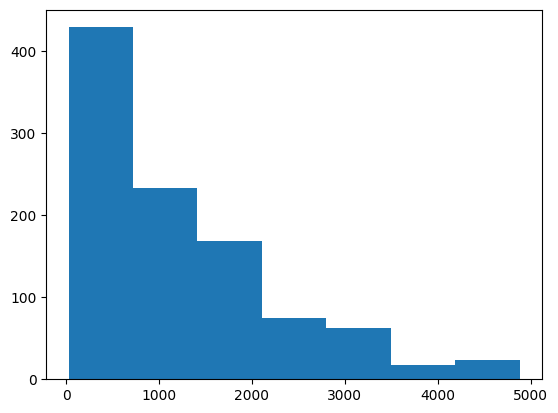

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(lesson_text_lens, bins=7)

We only care to keep description of the video which a lot of time is the first line but may be a few lines down

In [ ]:
# How long of a text covers 5% of the length
output_seq_len = int(np.percentile(lesson_text_lens, 5))
output_seq_len

48

In [ ]:
# Maxixum text length in training set
max(lesson_text_lens)

4881

In [ ]:
max_tokens = 10000
text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=output_seq_len
)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_lesson_texts)

In [ ]:
# Test out text vectorizer
import random
target_text = random.choice(train_lesson_texts)
print(f"Text:\n{target_text}")
print(f"\nLength of text: {len(target_text.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_text])}")

Text:
Beginner Guitar Tutorial: Master Finger Placement & Technique | Easy Guitar Lessons Welcome to our beginner guitar tutorial! In this video, we'll show you how to master proper finger placement and technique on the guitar.

As a beginner, it's essential to develop good habits and techniques from the start. Proper finger placement can make all the difference in your playing, helping you to avoid buzzing sounds, finger pain, and poor tone.

In this tutorial, we'll cover:

- How to place your fingers on the fretboard
- How to press the strings down correctly
- How to avoid buzzing sounds and finger pain
- Tips for developing good playing technique

By the end of this video, you'll have a solid understanding of proper finger placement and technique, and be well on your way to becoming a skilled guitar player.

So, grab your guitar and let's get started!

#GuitarTutorial #BeginnerGuitar #GuitarLessons #LearnGuitar #GuitarForBeginners #EasyGuitar #GuitarBasics #GuitarChords #GuitarStrum